In [195]:
import scipy as sp
import os
import numpy as np
import csv
import matplotlib.pyplot as pl
import datetime
import json
import shutil
import time



In [196]:
!pwd

/home/shruti/Documents/AL_120n_parallelised


In [197]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [199]:
# Get parameters

with open('input_modelparams.json', 'r') as read_file:
    params = json.load(read_file)

In [200]:
params

{u'I_extDC_LN': 0.5,
 u'I_extDC_PN': 1,
 u'dF_fGABA': 0.15,
 u'dF_nACH': 0.025,
 u'dF_sGABA': 0.005,
 u'gsyn_LNLN_fast': 0.1,
 u'gsyn_LNLN_fast_paper': 0.4,
 u'gsyn_LNPN_fast': 0.3,
 u'gsyn_LNPN_fast_paper': 0.8,
 u'gsyn_LNPN_slow': 0.015,
 u'gsyn_LNPN_slow_paper': 0.015,
 u'gsyn_PNLN': 0.05,
 u'gsyn_PNLN_paper': 0.35,
 u'number_excited_LN': 30,
 u'number_excited_PN': 90,
 u'peakcurrent_LN': 4.0,
 u'peakcurrent_PN': 7.5,
 u'pulse_width': 2000,
 u'start_pulse': 500,
 u'time_start': 0,
 u'time_step': 0.01,
 u'time_stop': 3000}

In [201]:
# create new directory for every new run and save nsets and ssets in that
 
date = datetime.date.today()
#print date

run_number = 1

dir = "{}_run{}".format(date,run_number)
print dir

os.makedirs(dir)
os.makedirs("{}/Figures".format(dir))

2018-10-29_run1


In [202]:
# make adjacency matrix
n = 120
p = 0.5
adjacency = np.zeros((n,n))


adjacency[:90,90:] = np.random.random_sample((90,30))
adjacency[90:,:90] = np.random.random_sample((30,90))
adjacency[90:,90:] = np.random.random_sample((30,30))


for x in range(0,n):
    for y in range(0,n):
        if adjacency[x,y] > p:
            adjacency[x,y] = 1
        else:
            adjacency[x,y] = 0
            
            
np.fill_diagonal(adjacency, 0)
#adjacency[0:90, 0:90] = 0

# Draw graph
#import graphviz as gv
#g1 = gv.Digraph(format = 'svg', engine = 'circo')

#for i in np.dstack(np.where(adjacency != 0))[0]:
 #   g1.edge('n{}'.format(i[0]), 'n{}'.format(i[1]))


In [203]:
# # Synapse info
# num_of_synapses = np.count_nonzero(adjacency)
# synapse = np.nonzero(adjacency)

# pre = synapse[0]
# post = synapse[1]

In [204]:
#nsets

file = open("{}/nsets_120n.isf".format(dir), "w")
for i in range(0, n):
    if i < 90:
        file.write('"PN {}"\n'.format(i))
        file.write('\t dxdt:6,\n')
        file.write('\t v:-30,\n')
        file.write('\t m:0,\n')
        file.write('\t n:0,\n')
        file.write('\t h:0,\n')
        file.write('\t ma:0,\n')
        file.write('\t ha:0,\n')
        file.write('\t I_NA:0,\n')
        file.write('\t I_K:0,\n')
        file.write('\t I_A:0,\n')
        file.write('\t I_LEAK:0,\n')
        file.write('\t I_KLEAK:0,\n')
        file.write('\t I_syn:0,\n')
        file.write('\t I_ext:{},\n'.format(params['I_extDC_PN']))
        file.write('\t last_spike:-10;\n')
        
    else:
        file.write('"LN {}"\n'.format(i))
        file.write('\t dxdt:7,\n')
        file.write('\t v:-30,\n')
        file.write('\t mk:0,\n')
        file.write('\t mca:0,\n')
        file.write('\t hca:0,\n')
        file.write('\t nk:0,\n')
        file.write('\t CA_DRIVE:0.00024,\n')
        file.write('\t I_KCA:0,\n')
        file.write('\t I_CA:0,\n')
        file.write('\t I_K_LN:0,\n')
        file.write('\t I_syn:0,\n')
        file.write('\t iext:{};\n'.format(params['I_extDC_LN']))

In [205]:
#copy paramter file to run folder
file = "input_modelparams.json"
shutil.copy(file, dir)

In [206]:
PNPN = adjacency[:90,:90]
PNLN = adjacency[:90,90:]
LNPN = adjacency[90:,:90]
LNLN = adjacency[90:,90:]

# LN - PN syn
sGABA_syn = adjacency[90:,:90]
sGABA_syn_index = np.nonzero(adjacency[90:,:90])
pre_sGABA = sGABA_syn_index[0]+90
post_sGABA = sGABA_syn_index[1]
print  np.count_nonzero(adjacency[90:,:90])

# PN - LN syn
nACH_syn = adjacency[:90,90:]
nACH_syn_index = np.nonzero(adjacency[:90,90:])
pre_nACH = nACH_syn_index[0]
post_nACH = nACH_syn_index[1]+90
print  np.count_nonzero(adjacency[:90,90:])

# LN - PN and LN - LN syn
fGABA_syn = adjacency[90:,:]
fGABA_syn_index = np.nonzero(adjacency[90:,:])
pre_fGABA = fGABA_syn_index[0]+90
post_fGABA = fGABA_syn_index[1]
print  np.count_nonzero(adjacency[90:,:])

num_of_synapses = np.count_nonzero(sGABA_syn) + np.count_nonzero(nACH_syn) + np.count_nonzero(fGABA_syn)

1330
1334
1760


In [261]:
#ssets

nACH = 0
fGABA = 0
sGABA = 0

file = open("{}/ssets_120.isf".format(dir,num_of_synapses), "w")

for i in range(0, num_of_synapses):
    
    #nACH syn
    if i in range(0, np.count_nonzero(nACH_syn)):
        file.write('"S {}"\n'.format(i))
        file.write('\t dxdt:1,\n')
        #file.write('\t F:1,\n')
        #file.write('\t F_i:1,\n')
        #file.write('\t t_i:0,\n')
        file.write('\t g1:0,\n')
        file.write('\t gsyn:{},\n'.format(params['gsyn_PNLN'])) #0.35 in paper #0.45
        file.write('\t esyn:0,\n')
        file.write('\t dF:{},\n'.format(params['dF_nACH']))
        file.write('\t pre:{},\n'.format(pre_nACH[i]))
        file.write('\t post:{};\n'.format(post_nACH[i]))
        nACH = nACH + 1 
       
    #fGABA syn 
    elif i in range(np.count_nonzero(nACH_syn), np.count_nonzero(nACH_syn) + np.count_nonzero(fGABA_syn)):
        file.write('"S {}"\n'.format(i))
        file.write('\t dxdt:1,\n')
       # file.write('\t F:1,\n')
       # file.write('\t F_i:1,\n')
       # file.write('\t t_i:0,\n')
        file.write('\t g1:0,\n')
        #file.write('\t g2:0,\n')
        #file.write('\t g3:0,\n')
        if post_fGABA[i - np.count_nonzero(nACH_syn)] < 90 :
            file.write('\t gsyn:{},\n'.format(params['gsyn_LNPN_fast'])) # 0.4 in paper
        elif post_fGABA[i - np.count_nonzero(nACH_syn)] > 90 :
            file.write('\t gsyn:{},\n'.format(params['gsyn_LNLN_fast']))
        file.write('\t esyn:-70,\n')
        file.write('\t dF:{},\n'.format(params['dF_fGABA']))
        #file.write('\t ek:-95,\n')
        file.write('\t pre:{},\n'.format(pre_fGABA[i - np.count_nonzero(nACH_syn)]))
        file.write('\t post:{};\n'.format(post_fGABA[i - np.count_nonzero(nACH_syn)]))
        fGABA = fGABA + 1  
        
    #sGABA_syn
    elif i in range(np.count_nonzero(nACH_syn) + np.count_nonzero(fGABA_syn), np.count_nonzero(sGABA_syn) + np.count_nonzero(nACH_syn) + np.count_nonzero(fGABA_syn)):
        file.write('"S {}"\n'.format(i))
        file.write('\t dxdt:2,\n')
       # file.write('\t F_slow:1,\n')
       # file.write('\t F_i_slow:1,\n')
       # file.write('\t t_i_slow:0,\n')
        #file.write('\t g1:0,\n')
        file.write('\t g2:0,\n')
        file.write('\t g3:0,\n')
        file.write('\t gsyn_slow:{},\n'.format(params['gsyn_LNPN_slow']))
        #file.write('\t gsyn:{},\n'.format(params['gsyn_LNPN_fast']))#0.8 in paper #0.45
        #file.write('\t esyn:-70,\n')
        file.write('\t ek:-95,\n')
        file.write('\t dF:{},\n'.format(params['dF_sGABA']))
        file.write('\t pre:{},\n'.format(pre_sGABA[i - np.count_nonzero(nACH_syn) - np.count_nonzero(fGABA_syn)]))
        file.write('\t post:{};\n'.format(post_sGABA[i - np.count_nonzero(nACH_syn) - np.count_nonzero(fGABA_syn)]))
        sGABA = sGABA + 1
        
print nACH,fGABA,sGABA

1334 1760 1330


In [242]:
i

4423

# # synapse = np.transpose(np.nonzero(adjacency))
# nACH = 0
# GABA = 0
# slow_GABA = 0
# file = open("{}/ssets_120.isf".format(dir,num_of_synapses), "w")
# for i in range(0, num_of_synapses):
#     # PN - LN connection (nACH) excitatory
# #     if pre[i] < 90 and post[i] >= 90:
#         file.write('"S {}"\n'.format(i))
#         file.write('\t dxdt:1,\n')
#         file.write('\t g1:0,\n')
#         file.write('\t gsyn:{},\n'.format(params['gsyn_PNLN'])) #0.35 in paper #0.45
#         file.write('\t esyn:0,\n')
#         file.write('\t pre:{},\n'.format(pre[i]))
#         file.write('\t post:{};\n'.format(post[i]))
#         nACH = nACH + 1          
#     # LN - PN connection (GABA)  inhibitory  and slow GABA           
#     elif pre[i] >= 90 and post[i] < 90:
#         file.write('"S {}"\n'.format(i))
#         file.write('\t dxdt:1,\n')
#         file.write('\t g1:0,\n')
#         #file.write('\t g2:0,\n')
#         #file.write('\t g3:0,\n')
#         #file.write('\t gsyn_slow:{},\n'.format(params['gsyn_LNPN_slow']))
#         file.write('\t gsyn:{},\n'.format(params['gsyn_LNPN_fast']))#0.8 in paper #0.45
#         file.write('\t esyn:-70,\n')
#         #file.write('\t ek:-95,\n')
#         file.write('\t pre:{},\n'.format(pre[i]))
#         file.write('\t post:{};\n'.format(post[i]))
        
#         GABA = GABA + 1  
#         slow_GABA = slow_GABA + 1
#     # LN - LN connection (GABA) inhibitory
#     elif pre[i] >=90 and post[i] >=90:
#         file.write('"S {}"\n'.format(i))
#         file.write('\t dxdt:1,\n')
#         file.write('\t g1:0,\n')
#         #file.write('\t g2:0,\n')
#         #file.write('\t g3:0,\n')
#         file.write('\t gsyn:{},\n'.format(params['gsyn_LNLN_fast'])) # 0.4 in paper
#         file.write('\t esyn:-70,\n')
#         #file.write('\t ek:-95,\n')
#         file.write('\t pre:{},\n'.format(pre[i]))
#         file.write('\t post:{};\n'.format(post[i]))
#         GABA = GABA + 1  

        
# print(GABA)
# print(slow_GABA)
# print(nACH)

In [210]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [211]:
#external current file generation - random values for current

#iext is the input, give to only 1/3rd and LNs
# iext for PN
number_excited_PN = params['number_excited_PN']
number_excited_LN = params['number_excited_LN']

mu_PN = number_excited_PN/2
sigma_PN = number_excited_PN/4

mu_LN = number_excited_LN/2
sigma_LN = number_excited_LN/4

#I_ext_indices_PN = np.random.choice(90, size=number_excited_PN, replace=False)
I_ext_indices_PN = np.arange(number_excited_PN)
I_ext_PN = np.zeros(90)

I_ext_PN[I_ext_indices_PN] = params['peakcurrent_PN']*gaussian(I_ext_indices_PN, mu_PN, sigma_PN)


#iext for LN
#I_ext_indices_LN = np.random.choice(30, size=number_excited_LN, replace=False) 
I_ext_indices_LN = np.arange(number_excited_LN)
I_ext_LN = np.zeros(30)

I_ext_LN[I_ext_indices_LN] = params['peakcurrent_LN']*gaussian(I_ext_indices_LN, mu_LN, sigma_LN)


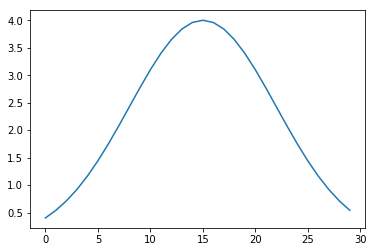

In [212]:
pl.plot(I_ext_LN)

In [174]:
print np.nonzero(I_ext_PN)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89]),)


In [94]:
# DC input - fill ext_current var

time_start = params['time_start']
time_stop = params['time_stop']
time_step = params['time_step']
time = np.arange(start = time_start, stop = time_stop, step = time_step)
ext_current = np.zeros((int(time_stop/time_step),121))

ext_current[:,0] = time
    
print ext_current.shape

for y in range(1,121):
    if y <= 90:
        ext_current[:,y] = I_ext_PN[y-1]
    else:
        ext_current[:,y] = I_ext_LN[y-91]
        
type_current_ip = "constant DC"

(300000, 121)


In [95]:
print int(time_stop/time_step)

300000


In [ ]:
# external current file generation - Pulsed input (50% duty cycle) - pulsed ip timeseries gen
time_start = params['time_start']
time_stop = params['time_stop']
time_step = params['time_step']
time = np.arange(start = time_start, stop = time_stop, step = time_step)
frequency_ipcurrent = 20


I_ext_PN_pulse = np.zeros((int(time_stop/time_step),90))
I_ext_LN_pulse = np.zeros((int(time_stop/time_step),30))

for y in range(0,120):
    if y < 90:
        I_ext_PN_pulse[:,y] = I_ext_PN[y]*(sp.signal.square(2*np.pi*frequency_ipcurrent/1000*time, duty = 0.5)/2 + 0.5)
    else:
        I_ext_LN_pulse[:,y-90] = I_ext_LN[y-90]*(sp.signal.square(2*np.pi*frequency_ipcurrent/1000*time, duty = 0.5)/2 + 0.5)
    
pl.plot(time,I_ext_LN_pulse[:,1])

In [ ]:
pl.plot(time,I_ext_LN_pulse[:,0])

In [ ]:
# external current file pulsed ip writing

ext_current = np.zeros((int(time_stop/time_step),121))


ext_current[:,0] = time

for y in range(1,121):
    if y<=90:
        ext_current[:,y] = I_ext_PN_pulse[:,y-1]
    else:
        ext_current[:,y] = I_ext_LN_pulse[:,y-91]
            
            
print ext_current[0:10000,90]

type_current_ip = "Pulsed at {} freq".format(frequency_ipcurrent)

In [97]:
pwd

u'/home/shruti/Documents/AL_120n_parallelised'

In [213]:
#external current long 2s pulse

time_start = params['time_start']
time_stop = params['time_stop']
time_step = params['time_step']
time = np.arange(start = time_start, stop = time_stop, step = time_step)


pulse_width = params['pulse_width']
start_pulse = params['start_pulse']
ext_current = np.zeros((int(time_stop/time_step),121))
ext_current[:,0] = time


for y in range(1,121):
    if y <= 90:
        ext_current[int(start_pulse/time_step):int(500/time_step)+int(pulse_width/time_step),y] = I_ext_PN[y-1]
    else:
        ext_current[int(start_pulse/time_step):int(500/time_step)+int(pulse_width/time_step),y] = I_ext_LN[y-91]
        
print ext_current

type_current_ip = "Long single pulse - DC"

[[0.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e-02 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.00000e-02 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [2.99997e+03 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.99998e+03 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.99999e+03 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]


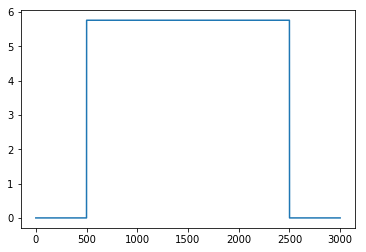

In [214]:
pl.plot(time,ext_current[:,30])

In [215]:
header = 'time' + ''.join([',{}'.format(i) for i in range(0,120)])

np.savetxt('{}/ecs_AL_120.isfc'.format(dir), ext_current, fmt='%.2f', delimiter = ',', header = header, comments='')

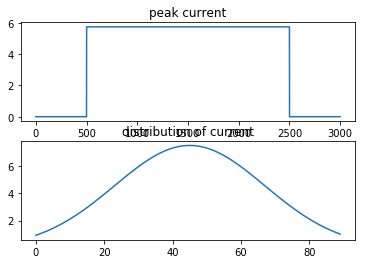

In [216]:
pl.subplot(211)
pl.plot(time,ext_current[:,30])
pl.title("peak current")
pl.subplot(212)
pl.plot(I_ext_PN)
pl.title("distribution of current")
pl.savefig("{}/Distribution of current".format(dir))

In [290]:
import subprocess

code = r'''
 #include "insilico/core.hpp"

#include "N_AL_PN.hpp"
#include "N_AL_LN.hpp"

#include <boost/numeric/odeint.hpp>
#include <fstream>
#include <iostream>
#include <iomanip>
#include <string>
#include <vector>
#include <omp.h>
#include <boost/numeric/odeint/external/openmp/openmp.hpp>

using namespace boost;
using namespace insilico;
using namespace std;

int main(int argc, char **argv) {
  // Commands to keep track of particular variables
  configuration::initialize(argc, argv);
  configuration::observe("v");  
  //configuration::observe_synapse(45,"gsyn");
  //configuration::observe_synapse(3100,"gsyn_slow"); 
  
  // Generate 90 PN neuron
  engine::generate_neuron<PN>(90);

  // Generate 30 LN neuron
  engine::generate_neuron<LN>(30);

  // Generate 1 S_nACH synapse between our neurons
  engine::generate_synapse<S_nACH>(%i);

  // Generate 1 S_2GABAA synapse between our neurons
  engine::generate_synapse<S_2GABAA>(%i);
  
  // Generate 1 S_slowGABA synapse between our neurons
  engine::generate_synapse<S_slowGABA>(%i);
 
  typedef numeric::odeint::runge_kutta4<
                      state_type , double ,
                      state_type , double ,
                      boost::numeric::odeint::openmp_range_algebra
                    >elr;
                    
                    
  omp_set_num_threads(6);

  //allowing the system to evolve
   state_type variables = engine::get_variables();
   integrate_const(elr(), engine::driver(), variables,
   0.0, 3000.0, 0.01, configuration::observer());
  configuration::finalize();
}


//#include "insilico/neuron/helper/spike_list.hpp"
//#include "S_nACH.hpp"
  //configuration::observe("ma");        
  //configuration::observe("ha");        
  //configuration::observe("I_A_ANTENNAL_LOBE_PN_HH");        
  //configuration::observe("I_KLEAK_ANTENNAL_LOBE_PN_HH");        

  // Generate 0 S_nACH synapse between our PN neurons
  //engine::generate_synapse<S_nACH>(0);

  // Spike list maintains neuron specific spike information (for the number of neurons in brackets)
  //engine::spike_list.resize(1);

'''% (nACH,fGABA,sGABA)

f_cpp = "main_120n.cpp"
with open(f_cpp,'w') as FOUT:
    FOUT.write(code)


In [295]:
# run cpp sim
!g++ -O3 -fopenmp -std=c++11 -Wall -I./insilico-0.25/include -o $dir/insilico_120n.out ./main_120n.cpp

In file included from ./insilico-0.25/include/insilico/core/engine/serial.hpp:26:0,
                 from ./insilico-0.25/include/insilico/core/engine.hpp:26,
                 from ./insilico-0.25/include/insilico/core/configuration/serial.hpp:24,
                 from ./insilico-0.25/include/insilico/core/configuration.hpp:27,
                 from ./insilico-0.25/include/insilico/core.hpp:23,
                 from ./main_120n.cpp:2:
./insilico-0.25/include/insilico/core/engine/generate.hpp: In member function ‘void insilico::engine::driver::operator()(insilico::state_type&, insilico::state_type&, double)’:
./insilico-0.25/include/insilico/core/engine/generate.hpp:91:15: warning: comparison between signed and unsigned integer expressions [-Wsign-compare]
  for(int i=0;i<neuron_objects_count.size();i++)
               ^
./insilico-0.25/include/insilico/core/engine/generate.hpp:106:15: warning: comparison between signed and unsigned integer expressions [-Wsign-compare]
  for(int i=0;i<s

In [289]:
import time
start = time.time()

!./$dir/insilico_120n.out -o $dir/final_120n.csv -n $dir/nsets_120n.isf -s $dir/ssets_120.isf -e $dir/ecs_AL_120.isfc
end = time.time()
print (end - start)/60

[insilico::configuration::initialize]SUCCESS: Initializing with following parameters:
Output file: 2018-10-29_run1/final_120n.csv
Neuron file: 2018-10-29_run1/nsets_120n.isf
Synapse file: 2018-10-29_run1/ssets_120.isf
External current file: 2018-10-29_run1/ecs_AL_120.isfc
[insilico::configuration::read] SUCCESS: Input file read complete.
Segmentation fault (core dumped)
0.0962557315826
